In [1]:
import json, os, re, networkx
from konlpy.utils import pprint
from konlpy.tag import Twitter
#from ckonlpy.tag import Twitter
#tw = Twitter()
import datetime

In [2]:
import sqlite3, io, json
import pandas as pd
from pandas import Series, DataFrame
from dateutil.parser import parse

In [6]:
con = sqlite3.connect("./data/convert.db")
cursor = con.cursor()
con.text_factory = bytes
df = pd.read_sql("SELECT * FROM content", con, index_col=None)
df = df.iloc[1:-1]
corpus = df.to_dict('records')

In [7]:
#따로 전처리할 필요 X
def preprocessing(content):
    #content = re.sub('[a-zA-Z]', '', content)
    content = re.sub('/(<([^>])>)/ig', '', content)
    content = re.sub('\\t', '', content)
    content = re.sub('\\n', '', content)
    content = re.sub('[\{\}\[\]\/?,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\")]', '', content)
    content = ' '.join(content.split())
    
    return content

In [8]:
#따로 토크나이징할 필요 X
def origin_tokenizing(content): #입력 문장 리스트를 토크나이징한다. Kkma는 pos로 분리하고, OS, NNG, NP만 빼내는 것이 좋다.
    featurelist = []
    tw = Twitter()
    for term in tw.pos(content):
        featurelist.append(term)
    return featurelist

In [9]:
class RawSentence: #문자열에 대한 처리
    def __init__(self, textIter):
        if type(textIter) == str: 
            self.textIter = textIter.split('\n')
        else: 
            self.textIter = textIter
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: 
                    continue
                yield s


In [10]:
class RawSentenceReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: 
                    continue
                yield s


In [11]:
utf_corpus = []
for i, data in enumerate(corpus):
    try:
        dd = dict()
        dd['title'] = data['title'].decode('utf-8')
        dd['content'] = data['content'].decode('utf-8')
        dd['link'] = data['link'].decode('utf-8')
        #dd['publish'] = datetime.datetime.strptime(data['publish'].decode('utf-8'), '%Y-%m-%d')
        dd['publish'] = data['publish'].decode('utf-8')
        dd['provider'] = data['provider'].decode('utf-8')
        #dd['tokens'] = origin_tokenizing(preprocessing(dd['content']))
    except Exception as err:
        print(i, err)
    finally:
        if len(dd.keys()) == 5: #tokens == 6, but so slow
            utf_corpus.append(dd)

In [12]:
class Docu:
    def __init__(self, content, link, provider, publish, title): #, tokens):
        self.content = content
        self.link = link
        self.provider = provider
        #self.publish = publish
        #self.publish = parse(publish)
        self.publish = datetime.datetime.strptime(publish, '%Y-%m-%d')
        self.title = title
        #self.tokens = tokens
    def __repr__(self):
        return repr((self.content, self.link, self.provider, self.publish, self.title))#, self.tokens))

In [13]:
#문서모음 객체화(정렬을 위함)
docments = list()
for i, data in enumerate(utf_corpus):
    docments.append(Docu(data['content'], data['link'], data['provider'], data['publish'], data['title']))#, data['tokens']))

In [14]:
#객체 날짜순 정렬(오름차순)
result = sorted(docments, key=lambda docu: docu.publish)
#정렬 확인
#for data in result:
#    print(data.publish.date())

In [15]:
#월별 데이터 묶음
predata = result[0]
datecorpus = {}
datecorpus[str(predata.publish.strftime("%Y-%m"))] = {'string' : predata.content + "\n"}

for i in range(1, len(result)):
    if result[i].publish.strftime("%Y-%m") == predata.publish.strftime("%Y-%m"):
        try:
            datecorpus[str(result[i].publish.strftime("%Y-%m"))]['string'] += str(result[i].content + "\n")
            #print(result[i].publish.date())
        except KeyError as e:
            datecorpus[str(result[i].publish.strftime("%Y-%m"))] = {'string' : str(result[i].content + "\n")}
            #print(e)
    predata = result[i]
    

## TextRank

In [16]:
class RawTagger:
    def __init__(self, textIter, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Twitter
            self.tagger = Twitter()
        if type(textIter) == str:
            self.textIter = textIter.split('\n')
        else: 
            self.textIter = textIter
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            if len(line) == 0:
                continue
            ch = self.rgxSplitter.split(line)
            if len(ch) == 1:
                ch.append('.')
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s) 

In [17]:
class RawTaggerReader:
    def __init__(self, filepath, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Twitter
            self.tagger = Twitter()
        self.filepath = filepath
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)


In [18]:
class TextRank:
    def __init__(self, **kargs):
        self.graph = None
        self.window = kargs.get('window', 5)
        self.coef = kargs.get('coef', 1.0)
        self.threshold = kargs.get('threshold', 0.005)
        self.dictCount = {}
        self.dictBiCount = {}
        self.dictNear = {}
        self.nTotal = 0
 
 
    def load(self, sentenceIter, wordFilter = None):
        def insertPair(a, b):
            if a > b: a, b = b, a
            elif a == b: return
            self.dictBiCount[a, b] = self.dictBiCount.get((a, b), 0) + 1
 
        def insertNearPair(a, b):
            self.dictNear[a, b] = self.dictNear.get((a, b), 0) + 1
 
        for sent in sentenceIter:
            for i, word in enumerate(sent):
                if wordFilter and not wordFilter(word): continue
                self.dictCount[word] = self.dictCount.get(word, 0) + 1
                self.nTotal += 1
                if i - 1 >= 0 and (not wordFilter or wordFilter(sent[i-1])): insertNearPair(sent[i-1], word)
                if i + 1 < len(sent) and (not wordFilter or wordFilter(sent[i+1])): insertNearPair(word, sent[i+1])
                for j in range(i+1, min(i+self.window+1, len(sent))):
                    if wordFilter and not wordFilter(sent[j]): continue
                    if sent[j] != word: insertPair(word, sent[j])
 
    def loadSents(self, sentenceIter, tokenizer = None):
        import math
        def similarity(a, b):
            n = len(a.intersection(b))
            return n / float(len(a) + len(b) - n) / (math.log(len(a)+1) * math.log(len(b)+1))
 
        if not tokenizer: rgxSplitter = re.compile('[\\s.,:;-?!()"\']+')
        sentSet = []
        for sent in filter(None, sentenceIter):
            if type(sent) == str:
                if tokenizer: s = set(filter(None, tokenizer(sent)))
                else: s = set(filter(None, rgxSplitter.split(sent)))
            else: s = set(sent)
            if len(s) < 2: continue
            self.dictCount[len(self.dictCount)] = sent
            sentSet.append(s)
 
        for i in range(len(self.dictCount)):
            for j in range(i+1, len(self.dictCount)):
                s = similarity(sentSet[i], sentSet[j])
                if s < self.threshold: continue
                self.dictBiCount[i, j] = s
 
    def getPMI(self, a, b):
        import math
        co = self.dictNear.get((a, b), 0)
        if not co: return None
        return math.log(float(co) * self.nTotal / self.dictCount[a] / self.dictCount[b])
 
    def getI(self, a):
        import math
        if a not in self.dictCount: return None
        return math.log(self.nTotal / self.dictCount[a])
 
    def build(self):
        self.graph = networkx.Graph()
        self.graph.add_nodes_from(self.dictCount.keys())
        for (a, b), n in self.dictBiCount.items():
            self.graph.add_edge(a, b, weight = n*self.coef + (1-self.coef))
 
    def rank(self):
        return networkx.pagerank(self.graph, weight='weight')
 
    def extract(self, ratio = 0.1):
        ranks = self.rank()
        cand = sorted(ranks, key=ranks.get, reverse=True)[:int(len(ranks) * ratio)]
        pairness = {}
        startOf = {}
        tuples = {}
        complex_pmi = []
        for k in cand:
            tuples[(k,)] = self.getI(k) * ranks[k]
            for l in cand:
                if k == l: continue
                pmi = self.getPMI(k, l)
                if pmi: pairness[k, l] = pmi
 
        for (k, l) in sorted(pairness, key=pairness.get, reverse=True):
            temp = (k[0]+l[0], pairness[k, l])
            complex_pmi.append(temp)
            if k not in startOf: startOf[k] = (k, l)
        return complex_pmi

        '''for (k, l), v in pairness.items():
            pmis = v
            rs = ranks[k] * ranks[l]
            path = (k, l)
            tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
            last = l
            while last in startOf and len(path) < 7:
                if last in path: break
                pmis += pairness[startOf[last]]
                last = startOf[last][1]
                rs *= ranks[last]
                path += (last,)
                tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
 
        used = set()
        both = {}
        for k in sorted(tuples, key=tuples.get, reverse=True):
            if used.intersection(set(k)): continue
            both[k] = tuples[k]
            for w in k: used.add(w)
 
        #for k in cand:
        #    if k not in used or True: both[k] = ranks[k] * self.getI(k)
 
        return both'''
 
    def summarize(self, ratio = 0.333):
        r = self.rank()
        ks = sorted(r, key=r.get, reverse=True)[:int(len(r)*ratio)]
        return ' '.join(map(lambda k:self.dictCount[k], sorted(ks)))


In [19]:
stopword = set([
                ('있', 'Verb'), ('하', 'Verb'), ('할', 'Verb'), ('되', 'Verb')
                , ('없', 'Verb'), ('위해', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective')
                , ('없다', 'Adjective'), ('통해', 'Noun'),('그럴', 'Adjective')
                , ('를', 'Noun'), ('는', 'Noun'), ('때문', 'Noun'), ('와', 'Noun')
                , ('전혀', 'Noun'), ('www','alpha')
               ])

In [20]:
sorted_word = {}
for date in list(datecorpus.keys()):
    tr = TextRank(window=1, coef=1, threshold = 5)
    %time tr.load(RawTagger(datecorpus[date]['string']), lambda w: w not in stopword and (w[1] in ('Noun', 'Adjective', 'Alpha', 'Number')))
    tr.build()
    datecorpus[date]['pmi'] = tr.extract(0.4)
    for data in datecorpus[date]['pmi']:
        try:
            sorted_word[data[0]][date] = data[1]
        except KeyError as e:
            sorted_word[data[0]] = {}
            sorted_word[data[0]][date] = data[1]

CPU times: user 15.3 s, sys: 1.57 s, total: 16.8 s
Wall time: 10.5 s
CPU times: user 7.01 s, sys: 0 ns, total: 7.01 s
Wall time: 6.62 s
CPU times: user 6.4 s, sys: 48 ms, total: 6.45 s
Wall time: 6.22 s
CPU times: user 5.36 s, sys: 20 ms, total: 5.38 s
Wall time: 5.2 s
CPU times: user 6.51 s, sys: 44 ms, total: 6.56 s
Wall time: 6.35 s
CPU times: user 6.51 s, sys: 32 ms, total: 6.54 s
Wall time: 6.34 s
CPU times: user 8.01 s, sys: 44 ms, total: 8.05 s
Wall time: 7.78 s
CPU times: user 7.61 s, sys: 60 ms, total: 7.67 s
Wall time: 7.44 s
CPU times: user 6.98 s, sys: 80 ms, total: 7.06 s
Wall time: 6.85 s
CPU times: user 5.96 s, sys: 44 ms, total: 6.01 s
Wall time: 5.82 s
CPU times: user 6.65 s, sys: 44 ms, total: 6.7 s
Wall time: 6.49 s
CPU times: user 5.15 s, sys: 20 ms, total: 5.17 s
Wall time: 5 s
CPU times: user 5.51 s, sys: 60 ms, total: 5.57 s
Wall time: 5.37 s
CPU times: user 7.47 s, sys: 56 ms, total: 7.52 s
Wall time: 7.27 s
CPU times: user 7.25 s, sys: 32 ms, total: 7.28 s
Wall

CPU times: user 5.5 s, sys: 24 ms, total: 5.52 s
Wall time: 5.35 s
CPU times: user 5.04 s, sys: 28 ms, total: 5.06 s
Wall time: 4.9 s
CPU times: user 5.49 s, sys: 40 ms, total: 5.53 s
Wall time: 5.36 s
CPU times: user 5.71 s, sys: 52 ms, total: 5.76 s
Wall time: 5.58 s
CPU times: user 9.42 s, sys: 52 ms, total: 9.47 s
Wall time: 9.17 s
CPU times: user 8.63 s, sys: 64 ms, total: 8.69 s
Wall time: 8.41 s
CPU times: user 7.98 s, sys: 80 ms, total: 8.06 s
Wall time: 7.79 s
CPU times: user 8.1 s, sys: 60 ms, total: 8.16 s
Wall time: 7.91 s
CPU times: user 8.09 s, sys: 52 ms, total: 8.14 s
Wall time: 7.9 s
CPU times: user 6.82 s, sys: 56 ms, total: 6.88 s
Wall time: 6.65 s
CPU times: user 6.91 s, sys: 84 ms, total: 7 s
Wall time: 6.77 s
CPU times: user 6.25 s, sys: 32 ms, total: 6.28 s
Wall time: 6.08 s
CPU times: user 8.15 s, sys: 56 ms, total: 8.2 s
Wall time: 7.94 s
CPU times: user 7.56 s, sys: 56 ms, total: 7.61 s
Wall time: 7.39 s
CPU times: user 7.07 s, sys: 48 ms, total: 7.12 s
Wall t

In [21]:
#save sorted_word
with io.open('./data/sorted_words.txt', 'w',encoding='utf-8') as f:
    f.write(json.dumps(sorted_word, ensure_ascii=False))
with io.open('./data/datecorpus.txt', 'w',encoding='utf-8') as f:
    f.write(json.dumps(datecorpus, ensure_ascii=False))

In [3]:
#load new JSON file 
with open('./data/sorted_words.txt', 'rt', encoding='utf-8') as json_data:
    sorted_word = json.load(json_data)
with open('./data/datecorpus.txt', 'rt', encoding='utf-8') as json_data:
    datecorpus = json.load(json_data)

In [18]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
a = fm.FontProperties(fname=font_list[0])
a.get_name()
font_list

['/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/droid/DroidSansEthiopic-Bold.ttf',
 '/usr/share/fonts/truetype/kacst/KacstLetter.ttf',
 '/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-BI.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypo-Bold.ttf',
 '/usr/share/fonts/truetype/ttf-indic-fonts-core/Malige-n.ttf',
 '/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOSsys.ttf',
 '/usr/share/fonts/truetype/tlwg/Waree-BoldOblique.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/unfonts-core/UnBatang.ttf',
 '/usr/share/fonts/truetype/ttf-indic-fonts-core/Rekha.ttf',
 '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-RI.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/unfonts-core/UnDinaruBold.ttf',
 '/usr/share/fonts/truetype/ttf

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc #TSNE 그림에서 한글이 깨지는 문제를 해결해준다.
font_fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (15,10)

In [5]:
a = list(sorted_word.keys())
date = list(datecorpus.keys())
for i, word in enumerate(sorted_word):
    if i < 1021035:
        continue
    #if i == 100 : break; #Graph Test
    dates = [mpl.dateutil.parser.parse(day) for day in list(sorted_word[a[i]].keys())]
    values = sorted_word[a[i]].values()
    plt.plot(dates, values, 'bs--' ,label=word)
    #plt.legend(loc='upper left')
    mindate = mpl.dateutil.parser.parse(date[0])
    maxdate = mpl.dateutil.parser.parse(date[-1])
    plt.xlim(mindate, maxdate)
    #plt.xticks(list(datecorpus.keys()))
    plt.ylim(0, 15)
    plt.xlabel('Date')
    plt.ylabel('Complex Word PMI')
    plt.title(word)
    fig = plt.gcf() #변경한 곳
    fig.savefig('./word_graph/'+word+'.png') #변경한 곳
    print(i)
    plt.cla()
    plt.clf()
    plt.close('all')

1021035
1021036
1021037
1021038
1021039
1021040
1021041
1021042
1021043
1021044
1021045
1021046
1021047
1021048
1021049
1021050
1021051
1021052
1021053
1021054
1021055
1021056
1021057
1021058
1021059
1021060
1021061
1021062
1021063
1021064
1021065
1021066
1021067
1021068
1021069
1021070
1021071
1021072
1021073
1021074
1021075
1021076
1021077
1021078
1021079
1021080
1021081
1021082
1021083
1021084
1021085
1021086
1021087
1021088
1021089
1021090
1021091
1021092
1021093
1021094
1021095
1021096
1021097
1021098
1021099
1021100
1021101
1021102
1021103
1021104
1021105
1021106
1021107
1021108
1021109
1021110
1021111
1021112
1021113
1021114
1021115
1021116
1021117
1021118
1021119
1021120
1021121
1021122
1021123
1021124
1021125
1021126
1021127
1021128
1021129
1021130
1021131
1021132
1021133
1021134
1021135
1021136
1021137
1021138
1021139
1021140
1021141
1021142
1021143
1021144
1021145
1021146
1021147
1021148
1021149
1021150
1021151
1021152
1021153
1021154
1021155
1021156
1021157
1021158
1021159


1022061
1022062
1022063
1022064
1022065
1022066
1022067
1022068
1022069
1022070
1022071
1022072
1022073
1022074
1022075
1022076
1022077
1022078
1022079
1022080
1022081
1022082
1022083
1022084
1022085
1022086
1022087
1022088
1022089
1022090
1022091
1022092
1022093
1022094
1022095
1022096
1022097
1022098
1022099
1022100
1022101
1022102
1022103
1022104
1022105
1022106
1022107
1022108
1022109
1022110
1022111
1022112
1022113
1022114
1022115
1022116
1022117
1022118
1022119
1022120
1022121
1022122
1022123
1022124
1022125
1022126
1022127
1022128
1022129
1022130
1022131
1022132
1022133
1022134
1022135
1022136
1022137
1022138
1022139
1022140
1022141
1022142
1022143
1022144
1022145
1022146
1022147
1022148
1022149
1022150
1022151
1022152
1022153
1022154
1022155
1022156
1022157
1022158
1022159
1022160
1022161
1022162
1022163
1022164
1022165
1022166
1022167
1022168
1022169
1022170
1022171
1022172
1022173
1022174
1022175
1022176
1022177
1022178
1022179
1022180
1022181
1022182
1022183
1022184
1022185


1023087
1023088
1023089
1023090
1023091
1023092
1023093
1023094
1023095
1023096
1023097
1023098
1023099
1023100
1023101
1023102
1023103
1023104
1023105
1023106
1023107
1023108
1023109
1023110
1023111
1023112
1023113
1023114
1023115
1023116
1023117
1023118
1023119
1023120
1023121
1023122
1023123
1023124
1023125
1023126
1023127
1023128
1023129
1023130
1023131
1023132
1023133
1023134
1023135
1023136
1023137
1023138
1023139
1023140
1023141
1023142
1023143
1023144
1023145
1023146
1023147
1023148
1023149
1023150
1023151
1023152
1023153
1023154
1023155
1023156
1023157
1023158
1023159
1023160
1023161
1023162
1023163
1023164
1023165
1023166
1023167
1023168
1023169
1023170
1023171
1023172
1023173
1023174
1023175
1023176
1023177
1023178
1023179
1023180
1023181
1023182
1023183
1023184
1023185
1023186
1023187
1023188
1023189
1023190
1023191
1023192
1023193
1023194
1023195
1023196
1023197
1023198
1023199
1023200
1023201
1023202
1023203
1023204
1023205
1023206
1023207
1023208
1023209
1023210
1023211


1024114
1024115
1024116
1024117
1024118
1024119
1024120
1024121
1024122
1024123
1024124
1024125
1024126
1024127
1024128
1024129
1024130
1024131
1024132
1024133
1024134
1024135
1024136
1024137
1024138
1024139
1024140
1024141
1024142
1024143
1024144
1024145
1024146
1024147
1024148
1024149
1024150
1024151
1024152
1024153
1024154
1024155
1024156
1024157
1024158
1024159
1024160
1024161
1024162
1024163
1024164
1024165
1024166
1024167
1024168
1024169
1024170
1024171
1024172
1024173
1024174
1024175
1024176
1024177
1024178
1024179
1024180
1024181
1024182
1024183
1024184
1024185
1024186
1024187
1024188
1024189
1024190
1024191
1024192
1024193
1024194
1024195
1024196
1024197
1024198
1024199
1024200
1024201
1024202
1024203
1024204
1024205
1024206
1024207
1024208
1024209
1024210
1024211
1024212
1024213
1024214
1024215
1024216
1024217
1024218
1024219
1024220
1024221
1024222
1024223
1024224
1024225
1024226
1024227
1024228
1024229
1024230
1024231
1024232
1024233
1024234
1024235
1024236
1024237
1024238


1025140
1025141
1025142
1025143
1025144
1025145
1025146
1025147
1025148
1025149
1025150
1025151
1025152
1025153
1025154
1025155
1025156
1025157
1025158
1025159
1025160
1025161
1025162
1025163
1025164
1025165
1025166
1025167
1025168
1025169
1025170
1025171
1025172
1025173
1025174
1025175
1025176
1025177
1025178
1025179
1025180
1025181
1025182
1025183
1025184
1025185
1025186
1025187
1025188
1025189
1025190
1025191
1025192
1025193
1025194
1025195
1025196
1025197
1025198
1025199
1025200
1025201
1025202
1025203
1025204
1025205
1025206
1025207
1025208
1025209
1025210
1025211
1025212
1025213
1025214
1025215
1025216
1025217
1025218
1025219
1025220
1025221
1025222
1025223
1025224
1025225
1025226
1025227
1025228
1025229
1025230
1025231
1025232
1025233
1025234
1025235
1025236
1025237
1025238
1025239
1025240
1025241
1025242
1025243
1025244
1025245
1025246
1025247
1025248
1025249
1025250
1025251
1025252
1025253
1025254
1025255
1025256
1025257
1025258
1025259
1025260
1025261
1025262
1025263
1025264


1026165
1026166
1026167
1026168
1026169
1026170
1026171
1026172
1026173
1026174
1026175
1026176
1026177
1026178
1026179
1026180
1026181
1026182
1026183
1026184
1026185
1026186
1026187
1026188
1026189
1026190
1026191
1026192
1026193
1026194
1026195
1026196
1026197
1026198
1026199
1026200
1026201
1026202
1026203
1026204
1026205
1026206
1026207
1026208
1026209
1026210
1026211
1026212
1026213
1026214
1026215
1026216
1026217
1026218
1026219
1026220
1026221
1026222
1026223
1026224
1026225
1026226
1026227
1026228
1026229
1026230
1026231
1026232
1026233
1026234
1026235
1026236
1026237
1026238
1026239
1026240
1026241
1026242
1026243
1026244
1026245
1026246
1026247
1026248
1026249
1026250
1026251
1026252
1026253
1026254
1026255
1026256
1026257
1026258
1026259
1026260
1026261
1026262
1026263
1026264
1026265
1026266
1026267
1026268
1026269
1026270
1026271
1026272
1026273
1026274
1026275
1026276
1026277
1026278
1026279
1026280
1026281
1026282
1026283
1026284
1026285
1026286
1026287
1026288
1026289


1027192
1027193
1027194
1027195
1027196
1027197
1027198
1027199
1027200
1027201
1027202
1027203
1027204
1027205
1027206
1027207
1027208
1027209
1027210
1027211
1027212
1027213
1027214
1027215
1027216
1027217
1027218
1027219
1027220
1027221
1027222
1027223
1027224
1027225
1027226
1027227
1027228
1027229
1027230
1027231
1027232
1027233
1027234
1027235
1027236
1027237
1027238
1027239
1027240
1027241
1027242
1027243
1027244
1027245
1027246
1027247
1027248
1027249
1027250
1027251
1027252
1027253
1027254
1027255
1027256
1027257
1027258
1027259
1027260
1027261
1027262
1027263
1027264
1027265
1027266
1027267
1027268
1027269
1027270
1027271
1027272
1027273
1027274
1027275
1027276
1027277
1027278
1027279
1027280
1027281
1027282
1027283
1027284
1027285
1027286
1027287
1027288
1027289
1027290
1027291
1027292
1027293
1027294
1027295
1027296
1027297
1027298
1027299
1027300
1027301
1027302
1027303
1027304
1027305
1027306
1027307
1027308
1027309
1027310
1027311
1027312
1027313
1027314
1027315
1027316


1028217
1028218
1028219
1028220
1028221
1028222
1028223
1028224
1028225
1028226
1028227
1028228
1028229
1028230
1028231
1028232
1028233
1028234
1028235
1028236
1028237
1028238
1028239
1028240
1028241
1028242
1028243
1028244
1028245
1028246
1028247
1028248
1028249
1028250
1028251
1028252
1028253
1028254
1028255
1028256
1028257
1028258
1028259
1028260
1028261
1028262
1028263
1028264
1028265
1028266
1028267
1028268
1028269
1028270
1028271
1028272
1028273
1028274
1028275
1028276
1028277
1028278
1028279
1028280
1028281
1028282
1028283
1028284
1028285
1028286
1028287
1028288
1028289
1028290
1028291
1028292
1028293
1028294
1028295
1028296
1028297
1028298
1028299
1028300
1028301
1028302
1028303
1028304
1028305
1028306
1028307
1028308
1028309
1028310
1028311
1028312
1028313
1028314
1028315
1028316
1028317
1028318
1028319
1028320
1028321
1028322
1028323
1028324
1028325
1028326
1028327
1028328
1028329
1028330
1028331
1028332
1028333
1028334
1028335
1028336
1028337
1028338
1028339
1028340
1028341


1029242
1029243
1029244
1029245
1029246
1029247
1029248
1029249
1029250
1029251
1029252
1029253
1029254
1029255
1029256
1029257
1029258
1029259
1029260
1029261
1029262
1029263
1029264
1029265
1029266
1029267
1029268
1029269
1029270
1029271
1029272
1029273
1029274
1029275
1029276
1029277
1029278
1029279
1029280
1029281
1029282
1029283
1029284
1029285
1029286
1029287
1029288
1029289
1029290
1029291
1029292
1029293
1029294
1029295
1029296
1029297
1029298
1029299
1029300
1029301
1029302
1029303
1029304
1029305
1029306
1029307
1029308
1029309
1029310
1029311
1029312
1029313
1029314
1029315
1029316
1029317
1029318
1029319
1029320
1029321
1029322
1029323
1029324
1029325
1029326
1029327
1029328
1029329
1029330
1029331
1029332
1029333
1029334
1029335
1029336
1029337
1029338
1029339
1029340
1029341
1029342
1029343
1029344
1029345
1029346
1029347
1029348
1029349
1029350
1029351
1029352
1029353
1029354
1029355
1029356
1029357
1029358
1029359
1029360
1029361
1029362
1029363
1029364
1029365
1029366


1030267
1030268
1030269
1030270
1030271
1030272
1030273
1030274
1030275
1030276
1030277
1030278
1030279
1030280
1030281
1030282
1030283
1030284
1030285
1030286
1030287
1030288
1030289
1030290
1030291
1030292
1030293
1030294
1030295
1030296
1030297
1030298
1030299
1030300
1030301
1030302
1030303
1030304
1030305
1030306
1030307
1030308
1030309
1030310
1030311
1030312
1030313
1030314
1030315
1030316
1030317
1030318
1030319
1030320
1030321
1030322
1030323
1030324
1030325
1030326
1030327
1030328
1030329
1030330
1030331
1030332
1030333
1030334
1030335
1030336
1030337
1030338
1030339
1030340
1030341
1030342
1030343
1030344
1030345
1030346
1030347
1030348
1030349
1030350
1030351
1030352
1030353
1030354
1030355
1030356
1030357
1030358
1030359
1030360
1030361
1030362
1030363
1030364
1030365
1030366
1030367
1030368
1030369
1030370
1030371
1030372
1030373
1030374
1030375
1030376
1030377
1030378
1030379
1030380
1030381
1030382
1030383
1030384
1030385
1030386
1030387
1030388
1030389
1030390
1030391


1031292
1031293
1031294
1031295
1031296
1031297
1031298
1031299
1031300
1031301
1031302
1031303
1031304
1031305
1031306
1031307
1031308
1031309
1031310
1031311
1031312
1031313
1031314
1031315
1031316
1031317
1031318
1031319
1031320
1031321
1031322
1031323
1031324
1031325
1031326
1031327
1031328
1031329
1031330
1031331
1031332
1031333
1031334
1031335
1031336
1031337
1031338
1031339
1031340
1031341
1031342
1031343
1031344
1031345
1031346
1031347
1031348
1031349
1031350
1031351
1031352
1031353
1031354
1031355
1031356
1031357
1031358
1031359
1031360
1031361
1031362
1031363
1031364
1031365
1031366
1031367
1031368
1031369
1031370
1031371
1031372
1031373
1031374
1031375
1031376
1031377
1031378
1031379
1031380
1031381
1031382
1031383
1031384
1031385
1031386
1031387
1031388
1031389
1031390
1031391
1031392
1031393
1031394
1031395
1031396
1031397
1031398
1031399
1031400
1031401
1031402
1031403
1031404
1031405
1031406
1031407
1031408
1031409
1031410
1031411
1031412
1031413
1031414
1031415
1031416


1032319
1032320
1032321
1032322
1032323
1032324
1032325
1032326
1032327
1032328
1032329
1032330
1032331
1032332
1032333
1032334
1032335
1032336
1032337
1032338
1032339
1032340
1032341
1032342
1032343
1032344
1032345
1032346
1032347
1032348
1032349
1032350
1032351
1032352
1032353
1032354
1032355
1032356
1032357
1032358
1032359
1032360
1032361
1032362
1032363
1032364
1032365
1032366
1032367
1032368
1032369
1032370
1032371
1032372
1032373
1032374
1032375
1032376
1032377
1032378
1032379
1032380
1032381
1032382
1032383
1032384
1032385
1032386
1032387
1032388
1032389
1032390
1032391
1032392
1032393
1032394
1032395
1032396
1032397
1032398
1032399
1032400
1032401
1032402
1032403
1032404
1032405
1032406
1032407
1032408
1032409
1032410
1032411
1032412
1032413
1032414
1032415
1032416
1032417
1032418
1032419
1032420
1032421
1032422
1032423
1032424
1032425
1032426
1032427
1032428
1032429
1032430
1032431
1032432
1032433
1032434
1032435
1032436
1032437
1032438
1032439
1032440
1032441
1032442
1032443


1033344
1033345
1033346
1033347
1033348
1033349
1033350
1033351
1033352
1033353
1033354
1033355
1033356
1033357
1033358
1033359
1033360
1033361
1033362
1033363
1033364
1033365
1033366
1033367
1033368
1033369
1033370
1033371
1033372
1033373
1033374
1033375
1033376
1033377
1033378
1033379
1033380
1033381
1033382
1033383
1033384
1033385
1033386
1033387
1033388
1033389
1033390
1033391
1033392
1033393
1033394
1033395
1033396
1033397
1033398
1033399
1033400
1033401
1033402
1033403
1033404
1033405
1033406
1033407
1033408
1033409
1033410
1033411
1033412
1033413
1033414
1033415
1033416
1033417
1033418
1033419
1033420
1033421
1033422
1033423
1033424
1033425
1033426
1033427
1033428
1033429
1033430
1033431
1033432
1033433
1033434
1033435
1033436
1033437
1033438
1033439
1033440
1033441
1033442
1033443
1033444
1033445
1033446
1033447
1033448
1033449
1033450
1033451
1033452
1033453
1033454
1033455
1033456
1033457
1033458
1033459
1033460
1033461
1033462
1033463
1033464
1033465
1033466
1033467
1033468


1034369
1034370
1034371
1034372
1034373
1034374
1034375
1034376
1034377
1034378
1034379
1034380
1034381
1034382
1034383
1034384
1034385
1034386
1034387
1034388
1034389
1034390
1034391
1034392
1034393
1034394
1034395
1034396
1034397
1034398
1034399
1034400
1034401
1034402
1034403
1034404
1034405
1034406
1034407
1034408
1034409
1034410
1034411
1034412
1034413
1034414
1034415
1034416
1034417
1034418
1034419
1034420
1034421
1034422
1034423
1034424
1034425
1034426
1034427
1034428
1034429
1034430
1034431
1034432
1034433
1034434
1034435
1034436
1034437
1034438
1034439
1034440
1034441
1034442
1034443
1034444
1034445
1034446
1034447
1034448
1034449
1034450
1034451
1034452
1034453
1034454
1034455
1034456
1034457
1034458
1034459
1034460
1034461
1034462
1034463
1034464
1034465
1034466
1034467
1034468
1034469
1034470
1034471
1034472
1034473
1034474
1034475
1034476
1034477
1034478
1034479
1034480
1034481
1034482
1034483
1034484
1034485
1034486
1034487
1034488
1034489
1034490
1034491
1034492
1034493


1035395
1035396
1035397
1035398
1035399
1035400
1035401
1035402
1035403
1035404
1035405
1035406
1035407
1035408
1035409
1035410
1035411
1035412
1035413
1035414
1035415
1035416
1035417
1035418
1035419
1035420
1035421
1035422
1035423
1035424
1035425
1035426
1035427
1035428
1035429
1035430
1035431
1035432
1035433
1035434
1035435
1035436
1035437
1035438
1035439
1035440
1035441
1035442
1035443
1035444
1035445
1035446
1035447
1035448
1035449
1035450
1035451
1035452
1035453
1035454
1035455
1035456
1035457
1035458
1035459
1035460
1035461
1035462
1035463
1035464
1035465
1035466
1035467
1035468
1035469
1035470
1035471
1035472
1035473
1035474
1035475
1035476
1035477
1035478
1035479
1035480
1035481
1035482
1035483
1035484
1035485
1035486
1035487
1035488
1035489
1035490
1035491
1035492
1035493
1035494
1035495
1035496
1035497
1035498
1035499
1035500
1035501
1035502
1035503
1035504
1035505
1035506
1035507
1035508
1035509
1035510
1035511
1035512
1035513
1035514
1035515
1035516
1035517
1035518
1035519


1036422
1036423
1036424
1036425
1036426
1036427
1036428
1036429
1036430
1036431
1036432
1036433
1036434
1036435
1036436
1036437
1036438
1036439
1036440
1036441
1036442
1036443
1036444
1036445
1036446
1036447
1036448
1036449
1036450
1036451
1036452
1036453
1036454
1036455
1036456
1036457
1036458
1036459
1036460
1036461
1036462
1036463
1036464
1036465
1036466
1036467
1036468
1036469
1036470
1036471
1036472
1036473
1036474
1036475
1036476
1036477
1036478
1036479
1036480
1036481
1036482
1036483
1036484
1036485
1036486
1036487
1036488
1036489
1036490
1036491
1036492
1036493
1036494
1036495
1036496
1036497
1036498
1036499
1036500
1036501
1036502
1036503
1036504
1036505
1036506
1036507
1036508
1036509
1036510
1036511
1036512
1036513
1036514
1036515
1036516
1036517
1036518
1036519
1036520
1036521
1036522
1036523
1036524
1036525
1036526
1036527
1036528
1036529
1036530
1036531
1036532
1036533
1036534
1036535
1036536
1036537
1036538
1036539
1036540
1036541
1036542
1036543
1036544
1036545
1036546


1037449
1037450
1037451
1037452
1037453
1037454
1037455
1037456
1037457
1037458
1037459
1037460
1037461
1037462
1037463
1037464
1037465
1037466
1037467
1037468
1037469
1037470
1037471
1037472
1037473
1037474
1037475
1037476
1037477
1037478
1037479
1037480
1037481
1037482
1037483
1037484
1037485
1037486
1037487
1037488
1037489
1037490
1037491
1037492
1037493
1037494
1037495
1037496
1037497
1037498
1037499
1037500
1037501
1037502
1037503
1037504
1037505
1037506
1037507
1037508
1037509
1037510
1037511
1037512
1037513
1037514
1037515
1037516
1037517
1037518
1037519
1037520
1037521
1037522
1037523
1037524
1037525
1037526
1037527
1037528
1037529
1037530
1037531
1037532
1037533
1037534
1037535
1037536
1037537
1037538
1037539
1037540
1037541
1037542
1037543
1037544
1037545
1037546
1037547
1037548
1037549
1037550
1037551
1037552
1037553
1037554
1037555
1037556
1037557
1037558
1037559
1037560
1037561
1037562
1037563
1037564
1037565
1037566
1037567
1037568
1037569
1037570
1037571
1037572
1037573


1038476
1038477
1038478
1038479
1038480
1038481
1038482
1038483
1038484
1038485
1038486
1038487
1038488
1038489
1038490
1038491
1038492
1038493
1038494
1038495
1038496
1038497
1038498
1038499
1038500
1038501
1038502
1038503
1038504
1038505
1038506
1038507
1038508
1038509
1038510
1038511
1038512
1038513
1038514
1038515
1038516
1038517
1038518
1038519
1038520
1038521
1038522
1038523
1038524
1038525
1038526
1038527
1038528
1038529
1038530
1038531
1038532
1038533
1038534
1038535
1038536
1038537
1038538
1038539
1038540
1038541
1038542
1038543
1038544
1038545
1038546
1038547
1038548
1038549
1038550
1038551
1038552
1038553
1038554
1038555
1038556
1038557
1038558
1038559
1038560
1038561
1038562
1038563
1038564
1038565
1038566
1038567
1038568
1038569
1038570
1038571
1038572
1038573
1038574
1038575
1038576
1038577
1038578
1038579
1038580
1038581
1038582
1038583
1038584
1038585
1038586
1038587
1038588
1038589
1038590
1038591
1038592
1038593
1038594
1038595
1038596
1038597
1038598
1038599
1038600


1039502
1039503
1039504
1039505
1039506
1039507
1039508
1039509
1039510
1039511
1039512
1039513
1039514
1039515
1039516
1039517
1039518
1039519
1039520
1039521
1039522
1039523
1039524
1039525
1039526
1039527
1039528
1039529
1039530
1039531
1039532
1039533
1039534
1039535
1039536
1039537
1039538
1039539
1039540
1039541
1039542
1039543
1039544
1039545
1039546
1039547
1039548
1039549
1039550
1039551
1039552
1039553
1039554
1039555
1039556
1039557
1039558
1039559
1039560
1039561
1039562
1039563
1039564
1039565
1039566
1039567
1039568
1039569
1039570
1039571
1039572
1039573
1039574
1039575
1039576
1039577
1039578
1039579
1039580
1039581
1039582
1039583
1039584
1039585
1039586
1039587
1039588
1039589
1039590
1039591
1039592
1039593
1039594
1039595
1039596
1039597
1039598
1039599
1039600
1039601
1039602
1039603
1039604
1039605
1039606
1039607
1039608
1039609
1039610
1039611
1039612
1039613
1039614
1039615
1039616
1039617
1039618
1039619
1039620
1039621
1039622
1039623
1039624
1039625
1039626


1040528
1040529
1040530
1040531
1040532
1040533
1040534
1040535
1040536
1040537
1040538
1040539
1040540
1040541
1040542
1040543
1040544
1040545
1040546
1040547
1040548
1040549
1040550
1040551
1040552
1040553
1040554
1040555
1040556
1040557
1040558
1040559
1040560
1040561
1040562
1040563
1040564
1040565
1040566
1040567
1040568
1040569
1040570
1040571
1040572
1040573
1040574
1040575
1040576
1040577
1040578
1040579
1040580
1040581
1040582
1040583
1040584
1040585
1040586
1040587
1040588
1040589
1040590
1040591
1040592
1040593
1040594
1040595
1040596
1040597
1040598
1040599
1040600
1040601
1040602
1040603
1040604
1040605
1040606
1040607
1040608
1040609
1040610
1040611
1040612
1040613
1040614
1040615
1040616
1040617
1040618
1040619
1040620
1040621
1040622
1040623
1040624
1040625
1040626
1040627
1040628
1040629
1040630
1040631
1040632
1040633
1040634
1040635
1040636
1040637
1040638
1040639
1040640
1040641
1040642
1040643
1040644
1040645
1040646
1040647
1040648
1040649
1040650
1040651
1040652


1041553
1041554
1041555
1041556
1041557
1041558
1041559
1041560
1041561
1041562
1041563
1041564
1041565
1041566
1041567
1041568
1041569
1041570
1041571
1041572
1041573
1041574
1041575
1041576
1041577
1041578
1041579
1041580
1041581
1041582
1041583
1041584
1041585
1041586
1041587
1041588
1041589
1041590
1041591
1041592
1041593
1041594
1041595
1041596
1041597
1041598
1041599
1041600
1041601
1041602
1041603
1041604
1041605
1041606
1041607
1041608
1041609
1041610
1041611
1041612
1041613
1041614
1041615
1041616
1041617
1041618
1041619
1041620
1041621
1041622
1041623
1041624
1041625
1041626
1041627
1041628
1041629
1041630
1041631
1041632
1041633
1041634
1041635
1041636
1041637
1041638
1041639
1041640
1041641
1041642
1041643
1041644
1041645
1041646
1041647
1041648
1041649
1041650
1041651
1041652
1041653
1041654
1041655
1041656
1041657
1041658
1041659
1041660
1041661
1041662
1041663
1041664
1041665
1041666
1041667
1041668
1041669
1041670
1041671
1041672
1041673
1041674
1041675
1041676
1041677


1042579
1042580
1042581
1042582
1042583
1042584
1042585
1042586
1042587
1042588
1042589
1042590
1042591
1042592
1042593
1042594
1042595
1042596
1042597
1042598
1042599
1042600
1042601
1042602
1042603
1042604
1042605
1042606
1042607
1042608
1042609
1042610
1042611
1042612
1042613
1042614
1042615
1042616
1042617
1042618
1042619
1042620
1042621
1042622
1042623
1042624
1042625
1042626
1042627
1042628
1042629
1042630
1042631
1042632
1042633
1042634
1042635
1042636
1042637
1042638
1042639
1042640
1042641
1042642
1042643
1042644
1042645
1042646
1042647
1042648
1042649
1042650
1042651
1042652
1042653
1042654
1042655
1042656
1042657
1042658
1042659
1042660
1042661
1042662
1042663
1042664
1042665
1042666
1042667
1042668
1042669
1042670
1042671
1042672
1042673
1042674
1042675
1042676
1042677
1042678
1042679
1042680
1042681
1042682
1042683
1042684
1042685
1042686
1042687
1042688
1042689
1042690
1042691
1042692
1042693
1042694
1042695
1042696
1042697
1042698
1042699
1042700
1042701
1042702
1042703


1043605
1043606
1043607
1043608
1043609
1043610
1043611
1043612
1043613
1043614
1043615
1043616
1043617
1043618
1043619
1043620
1043621
1043622
1043623
1043624
1043625
1043626
1043627
1043628
1043629
1043630
1043631
1043632
1043633
1043634
1043635
1043636
1043637
1043638
1043639
1043640
1043641
1043642
1043643
1043644
1043645
1043646
1043647
1043648
1043649
1043650
1043651
1043652
1043653
1043654
1043655
1043656
1043657
1043658
1043659
1043660
1043661
1043662
1043663
1043664
1043665
1043666
1043667
1043668
1043669
1043670
1043671
1043672
1043673
1043674
1043675
1043676
1043677
1043678
1043679
1043680
1043681
1043682
1043683
1043684
1043685
1043686
1043687
1043688
1043689
1043690
1043691
1043692
1043693
1043694
1043695
1043696
1043697
1043698
1043699
1043700
1043701
1043702
1043703
1043704
1043705
1043706
1043707
1043708
1043709
1043710
1043711
1043712
1043713
1043714
1043715
1043716
1043717
1043718
1043719
1043720
1043721
1043722
1043723
1043724
1043725
1043726
1043727
1043728
1043729


1044630
1044631
1044632
1044633
1044634
1044635
1044636
1044637
1044638
1044639
1044640
1044641
1044642
1044643
1044644
1044645
1044646
1044647
1044648
1044649
1044650
1044651
1044652
1044653
1044654
1044655
1044656
1044657
1044658
1044659
1044660
1044661
1044662
1044663
1044664
1044665
1044666
1044667
1044668
1044669
1044670
1044671
1044672
1044673
1044674
1044675
1044676
1044677
1044678
1044679
1044680
1044681
1044682
1044683
1044684
1044685
1044686
1044687
1044688
1044689
1044690
1044691
1044692
1044693
1044694
1044695
1044696
1044697
1044698
1044699
1044700
1044701
1044702
1044703
1044704
1044705
1044706
1044707
1044708
1044709
1044710
1044711
1044712
1044713
1044714
1044715
1044716
1044717
1044718
1044719
1044720
1044721
1044722
1044723
1044724
1044725
1044726
1044727
1044728
1044729
1044730
1044731
1044732
1044733
1044734
1044735
1044736
1044737
1044738
1044739
1044740
1044741
1044742
1044743
1044744
1044745
1044746
1044747
1044748
1044749
1044750
1044751
1044752
1044753
1044754


1045657
1045658
1045659
1045660
1045661
1045662
1045663
1045664
1045665
1045666
1045667
1045668
1045669
1045670
1045671
1045672
1045673
1045674
1045675
1045676
1045677
1045678
1045679
1045680
1045681
1045682
1045683
1045684
1045685
1045686
1045687
1045688
1045689
1045690
1045691
1045692
1045693
1045694
1045695
1045696
1045697
1045698
1045699
1045700
1045701
1045702
1045703
1045704
1045705
1045706
1045707
1045708
1045709
1045710
1045711
1045712
1045713
1045714
1045715
1045716
1045717
1045718
1045719
1045720
1045721
1045722
1045723
1045724
1045725
1045726
1045727
1045728
1045729
1045730
1045731
1045732
1045733
1045734
1045735
1045736
1045737
1045738
1045739
1045740
1045741
1045742
1045743
1045744
1045745
1045746
1045747
1045748
1045749
1045750
1045751
1045752
1045753
1045754
1045755
1045756
1045757
1045758
1045759
1045760
1045761
1045762
1045763
1045764
1045765
1045766
1045767
1045768
1045769
1045770
1045771
1045772
1045773
1045774
1045775
1045776
1045777
1045778
1045779
1045780
1045781


1046682
1046683
1046684
1046685
1046686
1046687
1046688
1046689
1046690
1046691
1046692
1046693
1046694
1046695
1046696
1046697
1046698
1046699
1046700
1046701
1046702
1046703
1046704
1046705
1046706
1046707
1046708
1046709
1046710
1046711
1046712
1046713
1046714
1046715
1046716
1046717
1046718
1046719
1046720
1046721
1046722
1046723
1046724
1046725
1046726
1046727
1046728
1046729
1046730
1046731
1046732
1046733
1046734
1046735
1046736
1046737
1046738
1046739
1046740
1046741
1046742
1046743
1046744
1046745
1046746
1046747
1046748
1046749
1046750
1046751
1046752
1046753
1046754
1046755
1046756
1046757
1046758
1046759
1046760
1046761
1046762
1046763
1046764
1046765
1046766
1046767
1046768
1046769
1046770
1046771
1046772
1046773
1046774
1046775
1046776
1046777
1046778
1046779
1046780
1046781
1046782
1046783
1046784
1046785
1046786
1046787
1046788
1046789
1046790
1046791
1046792
1046793
1046794
1046795
1046796
1046797
1046798
1046799
1046800
1046801
1046802
1046803
1046804
1046805
1046806


1047707
1047708
1047709
1047710
1047711
1047712
1047713
1047714
1047715
1047716
1047717
1047718
1047719
1047720
1047721
1047722
1047723
1047724
1047725
1047726
1047727
1047728
1047729
1047730
1047731
1047732
1047733
1047734
1047735
1047736
1047737
1047738
1047739
1047740
1047741
1047742
1047743
1047744
1047745
1047746
1047747
1047748
1047749
1047750
1047751
1047752
1047753
1047754
1047755
1047756
1047757
1047758
1047759
1047760
1047761
1047762
1047763
1047764
1047765
1047766
1047767
1047768
1047769
1047770
1047771
1047772
1047773
1047774
1047775
1047776
1047777
1047778
1047779
1047780
1047781
1047782
1047783
1047784
1047785
1047786
1047787
1047788
1047789
1047790
1047791
1047792
1047793
1047794
1047795
1047796
1047797
1047798
1047799
1047800
1047801
1047802
1047803
1047804
1047805
1047806
1047807
1047808
1047809
1047810
1047811
1047812
1047813
1047814
1047815
1047816
1047817
1047818
1047819
1047820
1047821
1047822
1047823
1047824
1047825
1047826
1047827
1047828
1047829
1047830
1047831


1048733
1048734
1048735
1048736
1048737
1048738
1048739
1048740
1048741
1048742
1048743
1048744
1048745
1048746
1048747
1048748
1048749
1048750
1048751
1048752
1048753
1048754
1048755
1048756
1048757
1048758
1048759
1048760
1048761
1048762
1048763
1048764
1048765
1048766
1048767
1048768
1048769
1048770
1048771
1048772
1048773
1048774
1048775
1048776
1048777
1048778
1048779
1048780
1048781
1048782
1048783
1048784
1048785
1048786
1048787
1048788
1048789
1048790
1048791
1048792
1048793
1048794
1048795
1048796
1048797
1048798
1048799
1048800
1048801
1048802
1048803
1048804
1048805
1048806
1048807
1048808
1048809
1048810
1048811
1048812
1048813
1048814
1048815
1048816
1048817
1048818
1048819
1048820
1048821
1048822
1048823
1048824
1048825
1048826
1048827
1048828
1048829
1048830
1048831
1048832
1048833
1048834
1048835
1048836
1048837
1048838
1048839
1048840
1048841
1048842
1048843
1048844
1048845
1048846
1048847
1048848
1048849
1048850
1048851
1048852
1048853
1048854
1048855
1048856
1048857


1049759
1049760
1049761
1049762
1049763
1049764
1049765
1049766
1049767
1049768
1049769
1049770
1049771
1049772
1049773
1049774
1049775
1049776
1049777
1049778
1049779
1049780
1049781
1049782
1049783
1049784
1049785
1049786
1049787
1049788
1049789
1049790
1049791
1049792
1049793
1049794
1049795
1049796
1049797
1049798
1049799
1049800
1049801
1049802
1049803
1049804
1049805
1049806
1049807
1049808
1049809
1049810
1049811
1049812
1049813
1049814
1049815
1049816
1049817
1049818
1049819
1049820
1049821
1049822
1049823
1049824
1049825
1049826
1049827
1049828
1049829
1049830
1049831
1049832
1049833
1049834
1049835
1049836
1049837
1049838
1049839
1049840
1049841
1049842
1049843
1049844
1049845
1049846
1049847
1049848
1049849
1049850
1049851
1049852
1049853
1049854
1049855
1049856
1049857
1049858
1049859
1049860
1049861
1049862
1049863
1049864
1049865
1049866
1049867
1049868
1049869
1049870
1049871
1049872
1049873
1049874
1049875
1049876
1049877
1049878
1049879
1049880
1049881
1049882
1049883


1050784
1050785
1050786
1050787
1050788
1050789
1050790
1050791
1050792
1050793
1050794
1050795
1050796
1050797
1050798
1050799
1050800
1050801
1050802
1050803
1050804
1050805
1050806
1050807
1050808
1050809
1050810
1050811
1050812
1050813
1050814
1050815
1050816
1050817
1050818
1050819
1050820
1050821
1050822
1050823
1050824
1050825
1050826
1050827
1050828
1050829
1050830
1050831
1050832
1050833
1050834
1050835
1050836
1050837
1050838
1050839
1050840
1050841
1050842
1050843
1050844
1050845
1050846
1050847
1050848
1050849
1050850
1050851
1050852
1050853
1050854
1050855
1050856
1050857
1050858
1050859
1050860
1050861
1050862
1050863
1050864
1050865
1050866
1050867
1050868
1050869
1050870
1050871
1050872
1050873
1050874
1050875
1050876
1050877
1050878
1050879
1050880
1050881
1050882
1050883
1050884
1050885
1050886
1050887
1050888
1050889
1050890
1050891
1050892
1050893
1050894
1050895
1050896
1050897
1050898
1050899
1050900
1050901
1050902
1050903
1050904
1050905
1050906
1050907
1050908


1051810
1051811
1051812
1051813
1051814
1051815
1051816
1051817
1051818
1051819
1051820
1051821
1051822
1051823
1051824
1051825
1051826
1051827
1051828
1051829
1051830
1051831
1051832
1051833
1051834
1051835
1051836
1051837
1051838
1051839
1051840
1051841
1051842
1051843
1051844
1051845
1051846
1051847
1051848
1051849
1051850
1051851
1051852
1051853
1051854
1051855
1051856
1051857
1051858
1051859
1051860
1051861
1051862
1051863
1051864
1051865
1051866
1051867
1051868
1051869
1051870
1051871
1051872
1051873
1051874
1051875
1051876
1051877
1051878
1051879
1051880
1051881
1051882
1051883
1051884
1051885
1051886
1051887
1051888
1051889
1051890
1051891
1051892
1051893
1051894
1051895
1051896
1051897
1051898
1051899
1051900
1051901
1051902
1051903
1051904
1051905
1051906
1051907
1051908
1051909
1051910
1051911
1051912
1051913
1051914
1051915
1051916
1051917
1051918
1051919
1051920
1051921
1051922
1051923
1051924
1051925
1051926
1051927
1051928
1051929
1051930
1051931
1051932
1051933
1051934


1052836
1052837
1052838
1052839
1052840
1052841
1052842
1052843
1052844
1052845
1052846
1052847
1052848
1052849
1052850
1052851
1052852
1052853
1052854
1052855
1052856
1052857
1052858
1052859
1052860
1052861
1052862
1052863
1052864
1052865
1052866
1052867
1052868
1052869
1052870
1052871
1052872
1052873
1052874
1052875
1052876
1052877
1052878
1052879
1052880
1052881
1052882
1052883
1052884
1052885
1052886
1052887
1052888
1052889
1052890
1052891
1052892
1052893
1052894
1052895
1052896
1052897
1052898
1052899
1052900
1052901
1052902
1052903
1052904
1052905
1052906
1052907
1052908
1052909
1052910
1052911
1052912
1052913
1052914
1052915
1052916
1052917
1052918
1052919
1052920
1052921
1052922
1052923
1052924
1052925
1052926
1052927
1052928
1052929
1052930
1052931
1052932
1052933
1052934
1052935
1052936
1052937
1052938
1052939
1052940
1052941
1052942
1052943
1052944
1052945
1052946
1052947
1052948
1052949
1052950
1052951
1052952
1052953
1052954
1052955
1052956
1052957
1052958
1052959
1052960


1053862
1053863
1053864
1053865
1053866
1053867
1053868
1053869
1053870
1053871
1053872
1053873
1053874
1053875
1053876
1053877
1053878
1053879
1053880
1053881
1053882
1053883
1053884
1053885
1053886
1053887
1053888
1053889
1053890
1053891
1053892
1053893
1053894
1053895
1053896
1053897
1053898
1053899
1053900
1053901
1053902
1053903
1053904
1053905
1053906
1053907
1053908
1053909
1053910
1053911
1053912
1053913
1053914
1053915
1053916
1053917
1053918
1053919
1053920
1053921
1053922
1053923
1053924
1053925
1053926
1053927
1053928
1053929
1053930
1053931
1053932
1053933
1053934
1053935
1053936
1053937
1053938
1053939
1053940
1053941
1053942
1053943
1053944
1053945
1053946
1053947
1053948
1053949
1053950
1053951
1053952
1053953
1053954
1053955
1053956
1053957
1053958
1053959
1053960
1053961
1053962
1053963
1053964
1053965
1053966
1053967
1053968
1053969
1053970
1053971
1053972
1053973
1053974
1053975
1053976
1053977
1053978
1053979
1053980
1053981
1053982
1053983
1053984
1053985
1053986


1054888
1054889
1054890
1054891
1054892
1054893
1054894
1054895
1054896
1054897
1054898
1054899
1054900
1054901
1054902
1054903
1054904
1054905
1054906
1054907
1054908
1054909
1054910
1054911
1054912
1054913
1054914
1054915
1054916
1054917
1054918
1054919
1054920
1054921
1054922
1054923
1054924
1054925
1054926
1054927
1054928
1054929
1054930
1054931
1054932
1054933
1054934
1054935
1054936
1054937
1054938
1054939
1054940
1054941
1054942
1054943
1054944
1054945
1054946
1054947
1054948
1054949
1054950
1054951
1054952
1054953
1054954
1054955
1054956
1054957
1054958
1054959
1054960
1054961
1054962
1054963
1054964
1054965
1054966
1054967
1054968
1054969
1054970
1054971
1054972
1054973
1054974
1054975
1054976
1054977
1054978
1054979
1054980
1054981
1054982
1054983
1054984
1054985
1054986
1054987
1054988
1054989
1054990
1054991
1054992
1054993
1054994
1054995
1054996
1054997
1054998
1054999
1055000
1055001
1055002
1055003
1055004
1055005
1055006
1055007
1055008
1055009
1055010
1055011
1055012


1055914
1055915
1055916
1055917
1055918
1055919
1055920
1055921
1055922
1055923
1055924
1055925
1055926
1055927
1055928
1055929
1055930
1055931
1055932
1055933
1055934
1055935
1055936
1055937
1055938
1055939
1055940
1055941
1055942
1055943
1055944
1055945
1055946
1055947
1055948
1055949
1055950
1055951
1055952
1055953
1055954
1055955
1055956
1055957
1055958
1055959
1055960
1055961
1055962
1055963
1055964
1055965
1055966
1055967
1055968
1055969
1055970
1055971
1055972
1055973
1055974
1055975
1055976
1055977
1055978
1055979
1055980
1055981
1055982
1055983
1055984
1055985
1055986
1055987
1055988
1055989
1055990
1055991
1055992
1055993
1055994
1055995
1055996
1055997
1055998
1055999
1056000
1056001
1056002
1056003
1056004
1056005
1056006
1056007
1056008
1056009
1056010
1056011
1056012
1056013
1056014
1056015
1056016
1056017
1056018
1056019
1056020
1056021
1056022
1056023
1056024
1056025
1056026
1056027
1056028
1056029
1056030
1056031
1056032
1056033
1056034
1056035
1056036
1056037
1056038


1056941
1056942
1056943
1056944
1056945
1056946
1056947
1056948
1056949
1056950
1056951
1056952
1056953
1056954
1056955
1056956
1056957
1056958
1056959
1056960
1056961
1056962
1056963
1056964
1056965
1056966
1056967
1056968
1056969
1056970
1056971
1056972
1056973
1056974
1056975
1056976
1056977
1056978
1056979
1056980
1056981
1056982
1056983
1056984
1056985
1056986
1056987
1056988
1056989
1056990
1056991
1056992
1056993
1056994
1056995
1056996
1056997
1056998
1056999
1057000
1057001
1057002
1057003
1057004
1057005
1057006
1057007
1057008
1057009
1057010
1057011
1057012
1057013
1057014
1057015
1057016
1057017
1057018
1057019
1057020
1057021
1057022
1057023
1057024
1057025
1057026
1057027
1057028
1057029
1057030
1057031
1057032
1057033
1057034
1057035
1057036
1057037
1057038
1057039
1057040
1057041
1057042
1057043
1057044
1057045
1057046
1057047
1057048
1057049
1057050
1057051
1057052
1057053
1057054
1057055
1057056
1057057
1057058
1057059
1057060
1057061
1057062
1057063
1057064
1057065


1057967
1057968
1057969
1057970
1057971
1057972
1057973
1057974
1057975
1057976
1057977
1057978
1057979
1057980
1057981
1057982
1057983
1057984
1057985
1057986
1057987
1057988
1057989
1057990
1057991
1057992
1057993
1057994
1057995
1057996
1057997
1057998
1057999
1058000
1058001
1058002
1058003
1058004
1058005
1058006
1058007
1058008
1058009
1058010
1058011
1058012
1058013
1058014
1058015
1058016
1058017
1058018
1058019
1058020
1058021
1058022
1058023
1058024
1058025
1058026
1058027
1058028
1058029
1058030
1058031
1058032
1058033
1058034
1058035
1058036
1058037
1058038
1058039
1058040
1058041
1058042
1058043
1058044
1058045
1058046
1058047
1058048
1058049
1058050
1058051
1058052
1058053
1058054
1058055
1058056
1058057
1058058
1058059
1058060
1058061
1058062
1058063
1058064
1058065
1058066
1058067
1058068
1058069
1058070
1058071
1058072
1058073
1058074
1058075
1058076
1058077
1058078
1058079
1058080
1058081
1058082
1058083
1058084
1058085
1058086
1058087
1058088
1058089
1058090
1058091


1058992
1058993
1058994
1058995
1058996
1058997
1058998
1058999
1059000
1059001
1059002
1059003
1059004
1059005
1059006
1059007
1059008
1059009
1059010
1059011
1059012
1059013
1059014
1059015
1059016
1059017
1059018
1059019
1059020
1059021
1059022
1059023
1059024
1059025
1059026
1059027
1059028
1059029
1059030
1059031
1059032
1059033
1059034
1059035
1059036
1059037
1059038
1059039
1059040
1059041
1059042
1059043
1059044
1059045
1059046
1059047
1059048
1059049
1059050
1059051
1059052
1059053
1059054
1059055
1059056
1059057
1059058
1059059
1059060
1059061
1059062
1059063
1059064
1059065
1059066
1059067
1059068
1059069
1059070
1059071
1059072
1059073
1059074
1059075
1059076
1059077
1059078
1059079
1059080
1059081
1059082
1059083
1059084
1059085
1059086
1059087
1059088
1059089
1059090
1059091
1059092
1059093
1059094
1059095
1059096
1059097
1059098
1059099
1059100
1059101
1059102
1059103
1059104
1059105
1059106
1059107
1059108
1059109
1059110
1059111
1059112
1059113
1059114
1059115
1059116


1060018
1060019
1060020
1060021
1060022
1060023
1060024
1060025
1060026
1060027
1060028
1060029
1060030
1060031
1060032
1060033
1060034
1060035
1060036
1060037
1060038
1060039
1060040
1060041
1060042
1060043
1060044
1060045
1060046
1060047
1060048
1060049
1060050
1060051
1060052
1060053
1060054
1060055
1060056
1060057
1060058
1060059
1060060
1060061
1060062
1060063
1060064
1060065
1060066
1060067
1060068
1060069
1060070
1060071
1060072
1060073
1060074
1060075
1060076
1060077
1060078
1060079
1060080
1060081
1060082
1060083
1060084
1060085
1060086
1060087
1060088
1060089
1060090
1060091
1060092
1060093
1060094
1060095
1060096
1060097
1060098
1060099
1060100
1060101
1060102
1060103
1060104
1060105
1060106
1060107
1060108
1060109
1060110
1060111
1060112
1060113
1060114
1060115
1060116
1060117
1060118
1060119
1060120
1060121
1060122
1060123
1060124
1060125
1060126
1060127
1060128
1060129
1060130
1060131
1060132
1060133
1060134
1060135
1060136
1060137
1060138
1060139
1060140
1060141
1060142


1061045
1061046
1061047
1061048
1061049
1061050
1061051
1061052
1061053
1061054
1061055
1061056
1061057
1061058
1061059
1061060
1061061
1061062
1061063
1061064
1061065
1061066
1061067
1061068
1061069
1061070
1061071
1061072
1061073
1061074
1061075
1061076
1061077
1061078
1061079
1061080
1061081
1061082
1061083
1061084
1061085
1061086
1061087
1061088
1061089
1061090
1061091
1061092
1061093
1061094
1061095
1061096
1061097
1061098
1061099
1061100
1061101
1061102
1061103
1061104
1061105
1061106
1061107
1061108
1061109
1061110
1061111
1061112
1061113
1061114
1061115
1061116
1061117
1061118
1061119
1061120
1061121
1061122
1061123
1061124
1061125
1061126
1061127
1061128
1061129
1061130
1061131
1061132
1061133
1061134
1061135
1061136
1061137
1061138
1061139
1061140
1061141
1061142
1061143
1061144
1061145
1061146
1061147
1061148
1061149
1061150
1061151
1061152
1061153
1061154
1061155
1061156
1061157
1061158
1061159
1061160
1061161
1061162
1061163
1061164
1061165
1061166
1061167
1061168
1061169


1062070
1062071
1062072
1062073
1062074
1062075
1062076
1062077
1062078
1062079
1062080
1062081
1062082
1062083
1062084
1062085
1062086
1062087
1062088
1062089
1062090
1062091
1062092
1062093
1062094
1062095
1062096
1062097
1062098
1062099
1062100
1062101
1062102
1062103
1062104
1062105
1062106
1062107
1062108
1062109
1062110
1062111
1062112
1062113
1062114
1062115
1062116
1062117
1062118
1062119
1062120
1062121
1062122
1062123
1062124
1062125
1062126
1062127
1062128
1062129
1062130
1062131
1062132
1062133
1062134
1062135
1062136
1062137
1062138
1062139
1062140
1062141
1062142
1062143
1062144
1062145
1062146
1062147
1062148
1062149
1062150
1062151
1062152
1062153
1062154
1062155
1062156
1062157
1062158
1062159
1062160
1062161
1062162
1062163
1062164
1062165
1062166
1062167
1062168
1062169
1062170
1062171
1062172
1062173
1062174
1062175
1062176
1062177
1062178
1062179
1062180
1062181
1062182
1062183
1062184
1062185
1062186
1062187
1062188
1062189
1062190
1062191
1062192
1062193
1062194


1063095
1063096
1063097
1063098
1063099
1063100
1063101
1063102
1063103
1063104
1063105
1063106
1063107
1063108
1063109
1063110
1063111
1063112
1063113
1063114
1063115
1063116
1063117
1063118
1063119
1063120
1063121
1063122
1063123
1063124
1063125
1063126
1063127
1063128
1063129
1063130
1063131
1063132
1063133
1063134
1063135
1063136
1063137
1063138
1063139
1063140
1063141
1063142
1063143
1063144
1063145
1063146
1063147
1063148
1063149
1063150
1063151
1063152
1063153
1063154
1063155
1063156
1063157
1063158
1063159
1063160
1063161
1063162
1063163
1063164
1063165
1063166
1063167
1063168
1063169
1063170
1063171
1063172
1063173
1063174
1063175
1063176
1063177
1063178
1063179
1063180
1063181
1063182
1063183
1063184
1063185
1063186
1063187
1063188
1063189
1063190
1063191
1063192
1063193
1063194
1063195
1063196
1063197
1063198
1063199
1063200
1063201
1063202
1063203
1063204
1063205
1063206
1063207
1063208
1063209
1063210
1063211
1063212
1063213
1063214
1063215
1063216
1063217
1063218
1063219


1064122
1064123
1064124
1064125
1064126
1064127
1064128
1064129
1064130
1064131
1064132
1064133
1064134
1064135
1064136
1064137
1064138
1064139
1064140
1064141
1064142
1064143
1064144
1064145
1064146
1064147
1064148
1064149
1064150
1064151
1064152
1064153
1064154
1064155
1064156
1064157
1064158
1064159
1064160
1064161
1064162
1064163
1064164
1064165
1064166
1064167
1064168
1064169
1064170
1064171
1064172
1064173
1064174
1064175
1064176
1064177
1064178
1064179
1064180
1064181
1064182
1064183
1064184
1064185
1064186
1064187
1064188
1064189
1064190
1064191
1064192
1064193
1064194
1064195
1064196
1064197
1064198
1064199
1064200
1064201
1064202
1064203
1064204
1064205
1064206
1064207
1064208
1064209
1064210
1064211
1064212
1064213
1064214
1064215
1064216
1064217
1064218
1064219
1064220
1064221
1064222
1064223
1064224
1064225
1064226
1064227
1064228
1064229
1064230
1064231
1064232
1064233
1064234
1064235
1064236
1064237
1064238
1064239
1064240
1064241
1064242
1064243
1064244
1064245
1064246


1065149
1065150
1065151
1065152
1065153
1065154
1065155
1065156
1065157
1065158
1065159
1065160
1065161
1065162
1065163
1065164
1065165
1065166
1065167
1065168
1065169
1065170
1065171
1065172
1065173
1065174
1065175
1065176
1065177
1065178
1065179
1065180
1065181
1065182
1065183
1065184
1065185
1065186
1065187
1065188
1065189
1065190
1065191
1065192
1065193
1065194
1065195
1065196
1065197
1065198
1065199
1065200
1065201
1065202
1065203
1065204
1065205
1065206
1065207
1065208
1065209
1065210
1065211
1065212
1065213
1065214
1065215
1065216
1065217
1065218
1065219
1065220
1065221
1065222
1065223
1065224
1065225
1065226
1065227
1065228
1065229
1065230
1065231
1065232
1065233
1065234
1065235
1065236
1065237
1065238
1065239
1065240
1065241
1065242
1065243
1065244
1065245
1065246
1065247
1065248
1065249
1065250
1065251
1065252
1065253
1065254
1065255
1065256
1065257
1065258
1065259
1065260
1065261
1065262
1065263
1065264
1065265
1065266
1065267
1065268
1065269
1065270
1065271
1065272
1065273


1066175
1066176
1066177
1066178
1066179
1066180
1066181
1066182
1066183
1066184
1066185
1066186
1066187
1066188
1066189
1066190
1066191
1066192
1066193
1066194
1066195
1066196
1066197
1066198
1066199
1066200
1066201
1066202
1066203
1066204
1066205
1066206
1066207
1066208
1066209
1066210
1066211
1066212
1066213
1066214
1066215
1066216
1066217
1066218
1066219
1066220
1066221
1066222
1066223
1066224
1066225
1066226
1066227
1066228
1066229
1066230
1066231
1066232
1066233
1066234
1066235
1066236
1066237
1066238
1066239
1066240
1066241
1066242
1066243
1066244
1066245
1066246
1066247
1066248
1066249
1066250
1066251
1066252
1066253
1066254
1066255
1066256
1066257
1066258
1066259
1066260
1066261
1066262
1066263
1066264
1066265
1066266
1066267
1066268
1066269
1066270
1066271
1066272
1066273
1066274
1066275
1066276
1066277
1066278
1066279
1066280
1066281
1066282
1066283
1066284
1066285
1066286
1066287
1066288
1066289
1066290
1066291
1066292
1066293
1066294
1066295
1066296
1066297
1066298
1066299


1067200
1067201
1067202
1067203
1067204
1067205
1067206
1067207
1067208
1067209
1067210
1067211
1067212
1067213
1067214
1067215
1067216
1067217
1067218
1067219
1067220
1067221
1067222
1067223
1067224
1067225
1067226
1067227
1067228
1067229
1067230
1067231
1067232
1067233
1067234
1067235
1067236
1067237
1067238
1067239
1067240
1067241
1067242
1067243
1067244
1067245
1067246
1067247
1067248
1067249
1067250
1067251
1067252
1067253
1067254
1067255
1067256
1067257
1067258
1067259
1067260
1067261
1067262
1067263
1067264
1067265
1067266
1067267
1067268
1067269
1067270
1067271
1067272
1067273
1067274
1067275
1067276
1067277
1067278
1067279
1067280
1067281
1067282
1067283
1067284
1067285
1067286
1067287
1067288
1067289
1067290
1067291
1067292
1067293
1067294
1067295
1067296
1067297
1067298
1067299
1067300
1067301
1067302
1067303
1067304
1067305
1067306
1067307
1067308
1067309
1067310
1067311
1067312
1067313
1067314
1067315
1067316
1067317
1067318
1067319
1067320
1067321
1067322
1067323
1067324


1068226
1068227
1068228
1068229
1068230
1068231
1068232
1068233
1068234
1068235
1068236
1068237
1068238
1068239
1068240
1068241
1068242
1068243
1068244
1068245
1068246
1068247
1068248
1068249
1068250
1068251
1068252
1068253
1068254
1068255
1068256
1068257
1068258
1068259
1068260
1068261
1068262
1068263
1068264
1068265
1068266
1068267
1068268
1068269
1068270
1068271
1068272
1068273
1068274
1068275
1068276
1068277
1068278
1068279
1068280
1068281
1068282
1068283
1068284
1068285
1068286
1068287
1068288
1068289
1068290
1068291
1068292
1068293
1068294
1068295
1068296
1068297
1068298
1068299
1068300
1068301
1068302
1068303
1068304
1068305
1068306
1068307
1068308
1068309
1068310
1068311
1068312
1068313
1068314
1068315
1068316
1068317
1068318
1068319
1068320
1068321
1068322
1068323
1068324
1068325
1068326
1068327
1068328
1068329
1068330
1068331
1068332
1068333
1068334
1068335
1068336
1068337
1068338
1068339
1068340
1068341
1068342
1068343
1068344
1068345
1068346
1068347
1068348
1068349
1068350


1069251
1069252
1069253
1069254
1069255
1069256
1069257
1069258
1069259
1069260
1069261
1069262
1069263
1069264
1069265
1069266
1069267
1069268
1069269
1069270
1069271
1069272
1069273
1069274
1069275
1069276
1069277
1069278
1069279
1069280
1069281
1069282
1069283
1069284
1069285
1069286
1069287
1069288
1069289
1069290
1069291
1069292
1069293
1069294
1069295
1069296
1069297
1069298
1069299
1069300
1069301
1069302
1069303
1069304
1069305
1069306
1069307
1069308
1069309
1069310
1069311
1069312
1069313
1069314
1069315
1069316
1069317
1069318
1069319
1069320
1069321
1069322
1069323
1069324
1069325
1069326
1069327
1069328
1069329
1069330
1069331
1069332
1069333
1069334
1069335
1069336
1069337
1069338
1069339
1069340
1069341
1069342
1069343
1069344
1069345
1069346
1069347
1069348
1069349
1069350
1069351
1069352
1069353
1069354
1069355
1069356
1069357
1069358
1069359
1069360
1069361
1069362
1069363
1069364
1069365
1069366
1069367
1069368
1069369
1069370
1069371
1069372
1069373
1069374
1069375


1070276
1070277
1070278
1070279
1070280
1070281
1070282
1070283
1070284
1070285
1070286
1070287
1070288
1070289
1070290
1070291
1070292
1070293
1070294
1070295
1070296
1070297
1070298
1070299
1070300
1070301
1070302
1070303
1070304
1070305
1070306
1070307
1070308
1070309
1070310
1070311
1070312
1070313
1070314
1070315
1070316
1070317
1070318
1070319
1070320
1070321
1070322
1070323
1070324
1070325
1070326
1070327
1070328
1070329
1070330
1070331
1070332
1070333
1070334
1070335
1070336
1070337
1070338
1070339
1070340
1070341
1070342
1070343
1070344
1070345
1070346
1070347
1070348
1070349
1070350
1070351
1070352
1070353
1070354
1070355
1070356
1070357
1070358
1070359
1070360
1070361
1070362
1070363
1070364
1070365
1070366
1070367
1070368
1070369
1070370
1070371
1070372
1070373
1070374
1070375
1070376
1070377
1070378
1070379
1070380
1070381
1070382
1070383
1070384
1070385
1070386
1070387
1070388
1070389
1070390
1070391
1070392
1070393
1070394
1070395
1070396
1070397
1070398
1070399
1070400


1071301
1071302
1071303
1071304
1071305
1071306
1071307
1071308
1071309
1071310
1071311
1071312
1071313
1071314
1071315
1071316
1071317
1071318
1071319
1071320
1071321
1071322
1071323
1071324
1071325
1071326
1071327
1071328
1071329
1071330
1071331
1071332
1071333
1071334
1071335
1071336
1071337
1071338
1071339
1071340
1071341
1071342
1071343
1071344
1071345
1071346
1071347
1071348
1071349
1071350
1071351
1071352
1071353
1071354
1071355
1071356
1071357
1071358
1071359
1071360
1071361
1071362
1071363
1071364
1071365
1071366
1071367
1071368
1071369
1071370
1071371
1071372
1071373
1071374
1071375
1071376
1071377
1071378
1071379
1071380
1071381
1071382
1071383
1071384
1071385
1071386
1071387
1071388
1071389
1071390
1071391
1071392
1071393
1071394
1071395
1071396
1071397
1071398
1071399
1071400
1071401
1071402
1071403
1071404
1071405
1071406
1071407
1071408
1071409
1071410
1071411
1071412
1071413
1071414
1071415
1071416
1071417
1071418
1071419
1071420
1071421
1071422
1071423
1071424
1071425


1072326
1072327
1072328
1072329
1072330
1072331
1072332
1072333
1072334
1072335
1072336
1072337
1072338
1072339
1072340


#### last is 1021035

In [74]:
mindate

datetime.datetime(2015, 5, 4, 0, 0)

In [76]:
maxdate

datetime.datetime(2015, 8, 14, 0, 0)

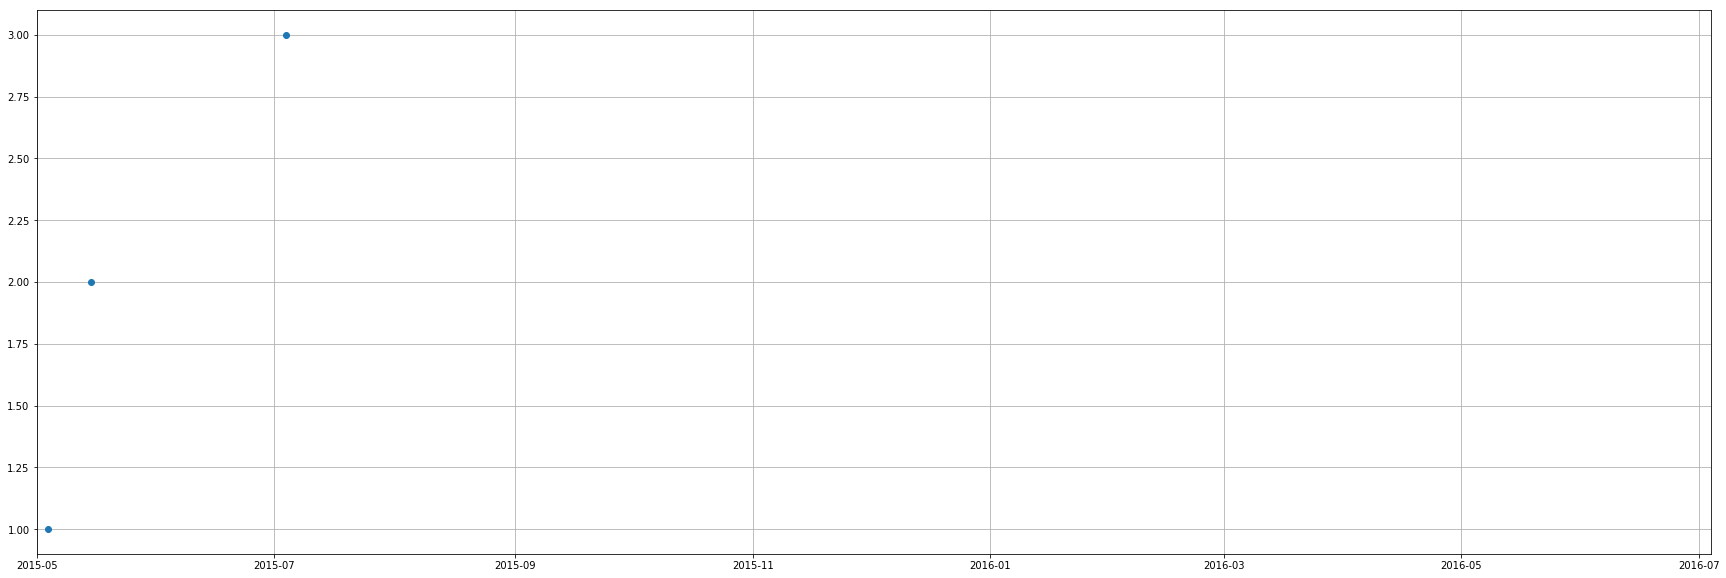

In [36]:
plt.rcParams["figure.figsize"] = (30,10)
plt.xlim(mpl.dateutil.parser.parse('2015-05-01'), mpl.dateutil.parser.parse('2016-07-04'))
plt.plot_date(dates, [1,2,3])

In [35]:
a = list(['b', 'c'])
b = ['b','c']
b-a

TypeError: unsupported operand type(s) for -: 'list' and 'list'